In [1]:
import glob
from timeit import default_timer as timer

import torch
import clip
from PIL import Image

import numpy as np
import pandas as pd
from tqdm import tqdm
import os
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.special

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [91]:
# CONSTANTS
MODEL = "RN50"
DATASET = "derm7pt"
ADDITIONAL_COMMENTS = "DETAILED_CONCEPT_PROMPTS_8"

In [64]:
# 1. Load Model and Processor
print("[INFO] Loading model...")

if MODEL == "ViT-B-32":
    model, preprocess = clip.load("ViT-B/32", device=device)
elif MODEL == "ViT-B-16":
    model, preprocess = clip.load("ViT-B/16", device=device)
elif MODEL == "RN50":
    model, preprocess = clip.load("RN50", device=device)
elif MODEL == "RN101":
    model, preprocess = clip.load("RN101", device=device)
elif MODEL == "ViT-L-14":
    model, preprocess = clip.load("ViT-L/14", device=device)
elif MODEL == "RN50x16":
    model, preprocess = clip.load("RN50x16", device=device)
elif MODEL == "ViT-B-32-FT":
    model, preprocess = clip.load("ViT-B/32", device=device)
    checkpoint = torch.load("ft_models/model_D7PT.pt")
    model.load_state_dict(checkpoint['model_state_dict'])
elif MODEL == "ViT-B-16-FT":
    model, preprocess = clip.load("ViT-B/16", device=device)
    checkpoint = torch.load("ft_models/model_D7PT_ViT16.pt")
    model.load_state_dict(checkpoint['model_state_dict'])

print("[INFO] Model loaded successfully!")

[INFO] Loading model...
[INFO] Model loaded successfully!


In [65]:
DETAILED_CONCEPT_PROMPTS_8 = {
    "TPN": ["This is dermatoscopy of regular and well-defined network of pigmented lines", 
            "This is dermatoscopy of characteristic reticular pattern of pigmentation",
            "This is dermatoscopy of symmetrical and distributed pigment network",
            "This is dermatoscopy of pigment network with uniform lines",
            "This is dermatoscopy of mesh-like pattern of pigmented lines"], 
    "APN": ["This is dermatoscopy of irregular and disrupted pigment network pattern", 
            "This is dermatoscopy of asymmetrical and distorted pigmented network",
            "This is dermatoscopy of atypical and non-uniform distribution of pigmented lines",
            "This is dermatoscopy of aberrant pigment network with irregular lines",
            "This is dermatoscopy of disrupted and disorganized pattern of pigmented lines"],
    "ISTR": ["This is dermatoscopy of asymmetric and irregularly distributed streaks", 
            "This is dermatoscopy of irregular pattern of linear streaks",
            "This is dermatoscopy of non-parallel and variably spaced streaks",
            "This is dermatoscopy of irregular streaks with varying thickness",
            "This is dermatoscopy of irregular arrangement of linear streaks"],
    "RSTR": ["This is dermatoscopy of regular pattern of linear streaks", 
            "This is dermatoscopy of symmetric and distributed streaks",
            "This is dermatoscopy of parallel and uniform streaks",
            "This is dermatoscopy of regular streaks with consistent thickness",
            "This is dermatoscopy of regular arrangement of linear streaks"],
    "RDG": ["This is dermatoscopy of regular round or oval-shaped dots and globules", 
            "This is dermatoscopy of symmetrically distributed dots and globules",
            "This is dermatoscopy of spaced and uniform-sized dots and globules",
            "This is dermatoscopy of regularly arranged dark or pigmented structures",
            "This is dermatoscopy of regular pattern of dots and globules"],
    "IDG": ["This is dermatoscopy of irregularly arranged dark or pigmented structures", 
            "This is dermatoscopy of asymmetrically distributed and irregularly shaped dots and globules",
            "This is dermatoscopy of irregular and variably sized dots and globules",
            "This is dermatoscopy of non-uniformly spaced and irregularly pigmented dots and globules",
            "This is dermatoscopy of irregular pattern of dots and globules"],
    "BWV": ["This is dermatoscopy of bluish-white coloration or opalescence", 
            "This is dermatoscopy of bluish-white hazy areas or veils",
            "This is dermatoscopy of blue whitish discoloration or haze",
            "This is dermatoscopy of whitish-blue cloudy patches or veils",
            "This is dermatoscopy of presence of blue whitish veils"],
    "RS": ["This is dermatoscopy of presence of regression structures", 
            "This is dermatoscopy of areas of hypopigmentation or scarring",
            "This is dermatoscopy of regressed or faded areas",
            "This is dermatoscopy of regression or involution",
            "This is dermatoscopy of regression in the form of depigmented or atrophic areas"]
}

In [66]:
REFERENCE_CONCEPT_PROMPTS = ["This is dermatoscopy"]

In [67]:
for concept in DETAILED_CONCEPT_PROMPTS_8.keys():
    print(f"**********{concept}**********")
    print(DETAILED_CONCEPT_PROMPTS_8[concept])

**********TPN**********
['This is dermatoscopy of regular and well-defined network of pigmented lines', 'This is dermatoscopy of characteristic reticular pattern of pigmentation', 'This is dermatoscopy of symmetrical and distributed pigment network', 'This is dermatoscopy of pigment network with uniform lines', 'This is dermatoscopy of mesh-like pattern of pigmented lines']
**********APN**********
['This is dermatoscopy of irregular and disrupted pigment network pattern', 'This is dermatoscopy of asymmetrical and distorted pigmented network', 'This is dermatoscopy of atypical and non-uniform distribution of pigmented lines', 'This is dermatoscopy of aberrant pigment network with irregular lines', 'This is dermatoscopy of disrupted and disorganized pattern of pigmented lines']
**********ISTR**********
['This is dermatoscopy of asymmetric and irregularly distributed streaks', 'This is dermatoscopy of irregular pattern of linear streaks', 'This is dermatoscopy of non-parallel and variably

In [68]:
# Extract text features for each concept and save it to a numpy array
for disease_label in DETAILED_CONCEPT_PROMPTS_8.keys():
    text = clip.tokenize(DETAILED_CONCEPT_PROMPTS_8[disease_label]).to(device)

    with torch.no_grad():
        text_features = model.encode_text(text)
    
    text_features /= text_features.norm(dim=-1, keepdim=True)
    
    np.save(f"text_embeddings/detailed_concept_8_embeddings_{disease_label}_{MODEL}.npy", text_features.detach().cpu().numpy())
print("[INFO] Completed!")

[INFO] Completed!


In [69]:
# Extract text features for each concept and save it to a numpy array
text = clip.tokenize(REFERENCE_CONCEPT_PROMPTS).to(device)

with torch.no_grad():
    text_features = model.encode_text(text)

text_features /= text_features.norm(dim=-1, keepdim=True)

#np.save(f"concept_embeddings/reference_embeddings_{MODEL}.npy", text_features.detach().cpu().numpy())
print("[INFO] Completed!")

[INFO] Completed!


In [70]:
from scipy.special import softmax

def get_similarity_score(image_features, text_features):
    similarity = np.dot(image_features, text_features.T)

    return similarity

In [71]:
def calculate_similarity_score(image_features_norm,
                               prompt_target_embedding_norm,
                               prompt_ref_embedding_norm,
                               temp=1,
                               top_k=-1,
                               normalize=True):

    #print(image_features_norm.shape)
    #print(prompt_target_embedding_norm.shape)
    #print(prompt_ref_embedding_norm.shape)

    target_similarity = prompt_target_embedding_norm.float() @ image_features_norm.T.float()
    ref_similarity = prompt_ref_embedding_norm.float() @ image_features_norm.T.float()


    if top_k > 0:
        idx_target = target_similarity.argsort(dim=1, descending=True)
        target_similarity_mean = target_similarity[:,idx_target.squeeze()[:top_k]].mean(dim=1)
        
        ref_similarity_mean = ref_similarity.mean(dim=1)
    else:
        target_similarity_mean = target_similarity.mean(dim=1)
        ref_similarity_mean = ref_similarity.mean(dim=1)
    
    if normalize:
        similarity_score = scipy.special.softmax([target_similarity_mean.numpy(), ref_similarity_mean.numpy()], axis=0)[0, :].mean(axis=0)
    else:
        similarity_score = target_similarity_mean.mean(axis=0)

    return similarity_score

In [92]:
# Get image embeddings 
print(f"[INFO] DATASET: {DATASET}")
print(f"[INFO] MODEL: {MODEL}")

img_embeddings = np.load(f"img_embeddings/image_embeddings_{DATASET}_CLIP_{MODEL}_Segmented_Norm.npy", allow_pickle=True).item()
reference_embeddings = torch.from_numpy(np.load(f"concept_embeddings/reference_embeddings_{MODEL}.npy")).unsqueeze(0)
weights_melanoma = np.load("/home/cristianopatricio/Desktop/PhD/Datasets/Skin/PH2Dataset/19-JUL-2023/log_reg_coefs_PH2_8_concepts.npy") # (1, 8)

results = dict()
# Iterate over images and calculate similarity
for im in img_embeddings.keys():
    img_feats = torch.from_numpy(img_embeddings[im]).unsqueeze(0)
    #print(f"IMG shape: {img_feats.shape}")

    similarity_scores = []
    for disease_label in DETAILED_CONCEPT_PROMPTS_8.keys():
        text_feats = torch.from_numpy(np.load(f"text_embeddings/detailed_concept_8_embeddings_{disease_label}_{MODEL}.npy")).unsqueeze(0)
        #print(f"TEXT shape: {text_feats.shape}")

        #similarity = get_similarity_score(img_feats, text_feats)
        similarity = calculate_similarity_score(image_features_norm=img_feats,
                                                prompt_target_embedding_norm=text_feats,
                                                prompt_ref_embedding_norm=reference_embeddings,
                                                top_k=2,
                                                temp=(1/np.exp(4.5944)))

        similarity_scores.append(similarity[0])

    # Calculate prediction given weights of melanoma
    y_pred = np.dot(weights_melanoma, np.array(similarity_scores))
    results[im] = y_pred

[INFO] DATASET: derm7pt
[INFO] MODEL: RN50


In [93]:
# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, balanced_accuracy_score, auc

if DATASET == "PH2":
    gt = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Datasets/Skin/PH2Dataset/PH2_dataset.csv")
    
    train_images_df = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Methods/CCNN_Pytorch/data/PH2_train.csv")
    train_images = train_images_df["images"].tolist()
    
    valiadtion_images_df = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Methods/CCNN_Pytorch/data/PH2_validation.csv")
    validation_images = valiadtion_images_df["images"].tolist()
    
    test_images_df = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Methods/CCNN_Pytorch/data/PH2_test.csv")
    test_images = test_images_df["images"].tolist()

elif DATASET == "derm7pt":
    gt = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Datasets/Skin/Derm7pt/image_classes_derm7pt.csv")
    
    train_images_df = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Methods/CCNN_Pytorch/data/derm7pt_train_seg.csv")
    train_images = train_images_df["images"].tolist()
    
    valiadtion_images_df = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Methods/CCNN_Pytorch/data/derm7pt_validation_seg.csv")
    validation_images = valiadtion_images_df["images"].tolist()
    
    test_images_df = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Methods/CCNN_Pytorch/data/derm7pt_test_seg.csv")
    test_images = test_images_df["images"].tolist()


y_true_val = []
y_pred_probs_val = []
for im in results.keys():

    if str(im) in validation_images:
        y_true_val.append(gt.loc[gt['images'] == str(im)]['labels'].tolist()[0])
        y_pred_probs_val.append(results[im])

fpr, tpr, thresholds = roc_curve(y_true_val, y_pred_probs_val)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

y_true = []
y_pred = []
y_pred_probs = []
for im in results.keys():
    
    if str(im) in test_images:
        y_true.append(gt.loc[gt['images'] == str(im)]['labels'].tolist()[0])
        y_pred.append(1 if results[im] > optimal_threshold else 0)
        y_pred_probs.append(results[im])

print(classification_report(y_true=y_true, y_pred=y_pred, target_names=["MEL", "NEV"]))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1]
FN = conf_matrix[1][0]
print(conf_matrix)

# Calculate AUC score
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc}")

# BACC
bacc = balanced_accuracy_score(y_true, y_pred)
print(f"BACC: {bacc}")

# Sensitivity
SE = TP / (TP + FN)
print(f"Sensitivity: {SE}")

# Specificity
SP = TN / (TN + FP)
print(f"Specificity: {SP}")

Threshold value is: 1.8952571356080026
              precision    recall  f1-score   support

         MEL       0.86      0.56      0.68       219
         NEV       0.46      0.80      0.58       101

    accuracy                           0.63       320
   macro avg       0.66      0.68      0.63       320
weighted avg       0.73      0.63      0.65       320

[[122  97]
 [ 20  81]]
AUC: 0.7634612776346127
BACC: 0.6795289117952892
Sensitivity: 0.801980198019802
Specificity: 0.5570776255707762


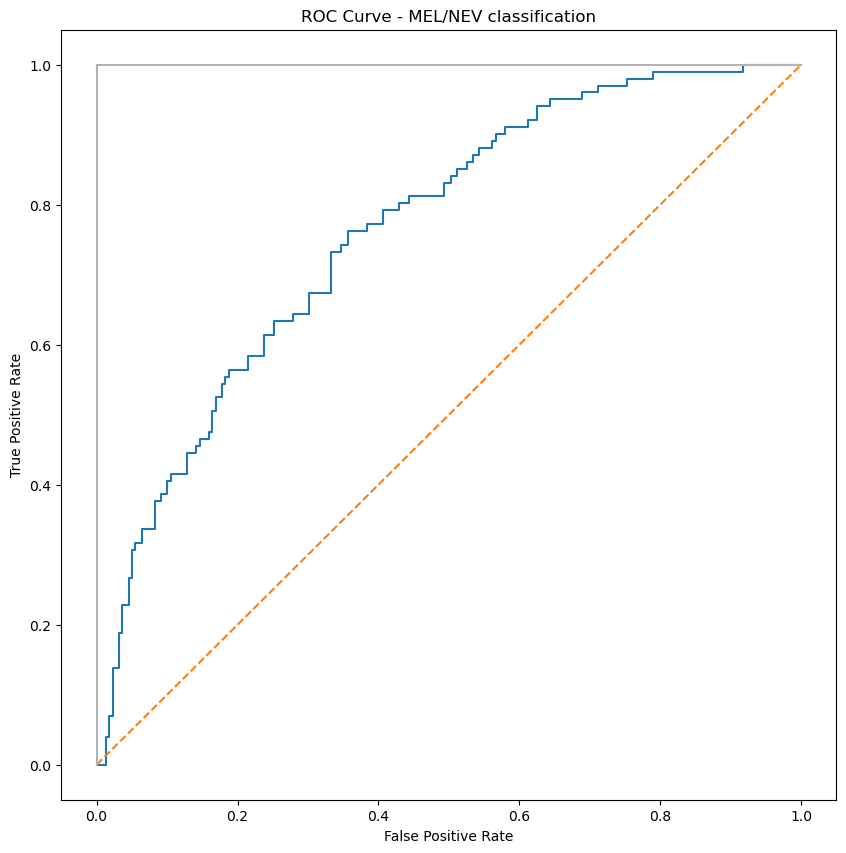

In [94]:
# Plot ROC AUC curve
import matplotlib.pyplot as plt

plt.subplots(1, figsize=(10,10))
plt.title('ROC Curve - MEL/NEV classification')
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()